# Candide Feature


# import

In [1]:
import sys
import time 
import math
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

sys.path.append("../../")

%run ../../ai/tf/setup/sess.py
%run ../../ai/common/images.py
%run ../../ai/nas/everyone/micro/model_inputs.py
%run ../../ac/profile/measure_time.py

# load dataset

In [3]:
tf_src_path = "/home/chy/archive-data/processed/everyone-tfr-candide"
tfrecord_files = glob.glob(os.path.join(tf_src_path, '*.tfr'))

batch_size = 8
for_lab = tfrecord_files[0:150]
data_iter = to_dataset(for_lab, batch_size=batch_size)
t_uid, t_frame, t_face, t_le, t_re, t_so, t_cam_x, t_cam_y, t_cam_to_x, t_cam_to_y, t_candide = data_iter.get_next()
tensors = [t_uid, t_frame, t_face, t_le, t_re, t_so, t_cam_x, t_cam_y, t_cam_to_x, t_cam_to_y, t_candide]

# vis

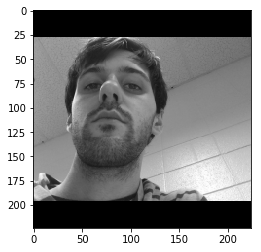

In [4]:
with tf.Session(config=get_sess_config()) as sess:
    sess.run(data_iter.initializer)
    
    uid, frame, _, _, _, so, cam_x, cam_y, cam_to_x, cam_to_y, candide = sess.run(tensors)
    
    img = frame[0]/255
    img = grey_to_color(img)
    plt.imshow(img)

# miscellaneous

In [ ]:
def show_good_and_bad(x, y, preds):
    fig = plot.figure(figsize=(10,20))
    for i in range(10):
        c = 1
        for (image, label, pred) in zip(x, y, preds):
            prediction, actual = np.argmax(pred), np.argmax(label)

            if prediction != i:
                continue

            if i != actual:
                subplot = fig.add_subplot(10,6, i*6+c)
                subplot.set_xticks([])
                subplot.set_yticks([])
                subplot.set_title('pred %d / act %d' % (prediction, actual))
                subplot.imshow(image.reshape((28,28)), vmin=0, vmax=1,cmap=plot.cm.gray_r)

                c += 1
                if c > 6:
                    break

In [5]:
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.last_epoch_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.last_epoch_start)
        
    def on_train_end(self, logs={}):
        print('\n==> Total time elapsed: ', self.total_time())
        
    def total_time(self): 
        return sum(self.times)

# EXP. pred by candide

In [7]:
size = 10000
x_train = []
y_train = []
x_test = []
y_test = []

with tf.Session(config=get_sess_config()) as sess:
    sess.run(data_iter.initializer)
    
    for i in range(size):
        _, _, _, _, _, so, cam_x, cam_y, cam_to_x, cam_to_y, candide = sess.run(tensors)
        for j in range(batch_size-1):
            X = np.split(candide[j], 20) + [cam_to_x[j], cam_to_y[j]]
            x_train.append(X)
            y_train.append((cam_x[j], cam_y[j]))
    
    for i in range(size):
        _, _, _, _, _, so, cam_x, cam_y, cam_to_x, cam_to_y, candide = sess.run(tensors)
        for j in range(batch_size-1):
            X = np.split(candide[j], 20) + [cam_to_x[j], cam_to_y[j]]
            x_test.append(X)
            y_test.append((cam_x[j], cam_y[j]))

# to DataFrame

In [122]:
df_train_x = pd.DataFrame(x_train)
df_train_y = pd.DataFrame(y_train)
df_test_x = pd.DataFrame(x_test)
df_test_y = pd.DataFrame(y_test)

In [31]:
display(df_train_x.describe())
display(df_train_y.describe())

,20,21
count,70000.000000,70000.000000
mean,2.219786,0.918638
std,0.343546,0.121981
min,1.496000,0.803000
25%,1.861000,0.803000
50%,2.354000,0.865000
75%,2.585000,1.065000
max,2.585000,1.065000


,0,1
count,70000.000000,70000.000000
mean,0.007460,-2.469504
std,5.125004,3.669897
min,-12.359456,-12.359456
25%,-3.051210,-4.888968
50%,0.301012,-1.578920
75%,3.116555,0.227769
max,12.359456,3.821517


# column shuffling

<br> 
- df_train_x[0].values shuffle (내부 상태 변경)
- 확인은 전후로 df.head(5) 비교하면 알 수 있음

# EXP. anatomy candide 20 

<br>
- size = 10000
<br>

|단계|요소|loss|acc|val loss|val acc|comment|
|-|-|-|-|-|-|-|
|candide|-|6.9475|0.9446|6.9277|0.9477
|상수(1)|-|19.8863|0.6798|20.8348|0.6738
|SO|-|7.3318|0.9523|5.4895|0.9620
||
|셔플|0|7.0342|0.9445|8.6226|0.9475
|제거|0|7.0070|0.9438|6.5621|0.9476
||
|셔플|1|7.0091|0.9441|6.8548|0.9473
|제거|1|6.9853|0.9444|8.0440|0.9460
||
|셔플|2|7.0193|0.9440|7.7065|0.9471
|제거|2|7.0251|0.9442|6.9633|0.9465
||
|셔플|3|8.4439|0.9255|7.1908|0.9469|중간 영향
|제거|3|8.3863|0.9249|6.7527|0.9475
||
|셔플|4|12.1440|0.8448|14.7555|0.7695|영향 큼. [4~6] translation으로 추정
|제거|4|11.8274|0.8459|12.9167|0.7905|섞는 것 보다 없는 것이 나을 만큼
||
|셔플|5|10.9776|0.9167|17.0037|0.9429|영향 큼.
|제거|5|10.8916|0.9130|10.0571|0.9433|
||
|셔플|6|8.4429|0.9250|6.7394|0.9474|중간 영향
|제거|6|8.3763|0.9258|6.9822|0.9473|
||
|셔플|7|8.4162|0.9256|6.8182|0.9478|
|제거|7|8.4071|0.9256|6.7163|0.9475|
||
|셔플|8|8.3906|0.9259|8.8224|0.9455|
|제거|8|8.3944|0.9258|6.9884|0.9472|




<br>

In [116]:
df_train_x.head(5)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,[203.67451],[-0.65698546],[0.09975263],[0.040111452],[230.7021],[165.25021],[0.18414289],[0.86449414],[0.032048803],[-0.12401078],...,[0.20265472],[-0.9233399],[1.7311907],[3.5848877],[0.038653165],[0.0511477],[0.06919209],[-0.03231669],1.861,0.803
1,[177.3606],[-0.7454374],[0.07449965],[-0.1901389],[179.78726],[248.52698],[0.78322357],[0.7488552],[0.053618263],[-0.016249973],...,[0.527069],[-1.197338],[2.076642],[3.876542],[0.00019659546],[-0.004985013],[0.06331434],[-0.053638928],2.585,1.065
2,[126.240616],[-0.62487185],[-0.040893428],[0.086390324],[291.45575],[172.15685],[0.41989675],[0.60321057],[0.064249784],[-0.043455414],...,[0.49691582],[-1.1355625],[1.1489538],[2.4393966],[-0.023829171],[0.019627713],[0.03805963],[-0.03227601],2.585,1.065
3,[198.24219],[-0.13438718],[-0.2944141],[-0.039364558],[431.4689],[194.6395],[-0.09881125],[0.10260948],[0.43113855],[-0.23600298],...,[4.194708],[-4.6452794],[0.8095182],[0.07215674],[0.015815232],[0.039295077],[0.04233542],[-0.0278531],1.861,0.804
4,[223.21838],[-0.16121262],[0.12034277],[-0.052775037],[237.21693],[412.6297],[-0.12801002],[0.7206027],[0.22486085],[0.044166055],...,[3.9159987],[-3.6971257],[0.85597676],[1.8327193],[0.021356564],[0.026023246],[0.056975223],[-0.04880165],1.861,0.804


In [117]:
debug_index = 8
# np.random.shuffle(df_train_x[debug_index].values)    # in-place

df_train_x = df_train_x.drop([debug_index], axis=1)    # out-place
df_test_x = df_test_x.drop([debug_index], axis=1)    # out-place

In [118]:
df_train_x.head(5)

,0,1,2,3,4,5,6,7,9,10,...,12,13,14,15,16,17,18,19,20,21
0,[203.67451],[-0.65698546],[0.09975263],[0.040111452],[230.7021],[165.25021],[0.18414289],[0.86449414],[-0.12401078],[0.23525551],...,[0.20265472],[-0.9233399],[1.7311907],[3.5848877],[0.038653165],[0.0511477],[0.06919209],[-0.03231669],1.861,0.803
1,[177.3606],[-0.7454374],[0.07449965],[-0.1901389],[179.78726],[248.52698],[0.78322357],[0.7488552],[-0.016249973],[-0.13878603],...,[0.527069],[-1.197338],[2.076642],[3.876542],[0.00019659546],[-0.004985013],[0.06331434],[-0.053638928],2.585,1.065
2,[126.240616],[-0.62487185],[-0.040893428],[0.086390324],[291.45575],[172.15685],[0.41989675],[0.60321057],[-0.043455414],[0.09396868],...,[0.49691582],[-1.1355625],[1.1489538],[2.4393966],[-0.023829171],[0.019627713],[0.03805963],[-0.03227601],2.585,1.065
3,[198.24219],[-0.13438718],[-0.2944141],[-0.039364558],[431.4689],[194.6395],[-0.09881125],[0.10260948],[-0.23600298],[0.092015766],...,[4.194708],[-4.6452794],[0.8095182],[0.07215674],[0.015815232],[0.039295077],[0.04233542],[-0.0278531],1.861,0.804
4,[223.21838],[-0.16121262],[0.12034277],[-0.052775037],[237.21693],[412.6297],[-0.12801002],[0.7206027],[0.044166055],[0.23001081],...,[3.9159987],[-3.6971257],[0.85597676],[1.8327193],[0.021356564],[0.026023246],[0.056975223],[-0.04880165],1.861,0.804


# model

In [120]:
l2_reg = tf.keras.regularizers.l2
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
  
    tf.keras.layers.Dense(512, kernel_regularizer=l2_reg(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(2)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
timeHistory = TimeHistory()

# train


|#batch|loss|acc|val loss|val acc|
|-|-|-|-|-|
|1|19|60|20|60|
|2|15.0116|0.8258|10.6952|0.9450|
|4|10.6105|0.8944|7.5303|0.9468|


<br>

In [121]:
tx = df_train_x.values
ty = df_train_y.values
vx = df_test_x.values
vy = df_test_y.values
model.fit(tx, ty, 
          validation_data=(vx, vy),
          callbacks=[timeHistory],
          batch_size=8,
          verbose=1, 
          epochs=5)

Train on 70000 samples, validate on 70000 samples
Epoch 1/5
70000/70000 [==============================] - 65s 927us/step - loss: 8.9156 - acc: 0.9251 - val_loss: 7.0358 - val_acc: 0.9473
Epoch 2/5
70000/70000 [==============================] - 63s 896us/step - loss: 8.5083 - acc: 0.9253 - val_loss: 7.2202 - val_acc: 0.9467
Epoch 3/5
70000/70000 [==============================] - 63s 899us/step - loss: 8.4622 - acc: 0.9251 - val_loss: 6.9041 - val_acc: 0.9473
Epoch 4/5
70000/70000 [==============================] - 63s 895us/step - loss: 8.4534 - acc: 0.9256 - val_loss: 6.6393 - val_acc: 0.9476
Epoch 5/5
70000/70000 [==============================] - 62s 886us/step - loss: 8.3944 - acc: 0.9258 - val_loss: 6.9884 - val_acc: 0.9472

==> Total time elapsed:  315.1980700492859


# loss 단위 체크

In [ ]:
print(df_test_x.iloc[0])
print(df_test_y.iloc[0])

In [ ]:
df_target_x = df_test_x[df_test_x.index < 1000]
df_target_y = df_test_y[df_test_y.index < 1000]

In [ ]:
display(df_target_x)
display(df_target_y)

In [ ]:
preds = model.predict(df_target_x.values)

In [ ]:
preds

In [ ]:
df_preds = pd.DataFrame(preds)

In [ ]:
df_preds.columns = ['px', 'py']

In [ ]:
diff = df_preds - df_target_y

In [ ]:
dist = [diff[0]**2 + diff[1]**2]

In [ ]:
np.average(dist)

# merge pred and truth

In [ ]:
df_target_y.columns = ["tx", "ty"]

In [ ]:
df_merged = pd.concat([df_preds, df_target_y], axis=1)

In [ ]:
df_merged

In [ ]:
df_dist = pd.DataFrame(dist)

In [ ]:
df_dist.T / 2

In [ ]:
df_dist.T.describe()

In [ ]:
df_dist.T.hist(bins=500)
plt.show()

In [66]:
tdf = pd.read_csv('/home/chy/dev-bench/auto-history/only-orient')

In [65]:
tdf.describe()

,9.059275
count,10239.000000
mean,14.937853
std,5.672530
min,2.229936
25%,10.746771
50%,14.250405
75%,18.412348
max,41.334442


In [70]:
tdf.mean() / 8

9.059275    1.867232
dtype: float64